# 03 – Baseline Modeling: Logistic Regression

Ziel dieses Notebooks ist der Aufbau eines einfachen, aber aussagekräftigen
Baseline-Modells für Fraud Risk Scoring.

Die Baseline dient als Referenzpunkt, um spätere komplexere Modelle
(z. B. Neural Networks) sinnvoll bewerten zu können.

Fokus:
- probabilistische Vorhersagen (Risk Scores)
- geeignete Metriken für extreme Klassen-Unbalance
- Verständnis der Trade-offs zwischen False Positives und False Negatives


In [2]:
import sys, os, numpy as np
import sklearn, scipy

print("sys.executable:", sys.executable)
print("sys.version:", sys.version)
print("cwd:", os.getcwd())
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sklearn.__version__)


sys.executable: C:\Users\admin\miniforge3\envs\fraudml\python.exe
sys.version: 3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:35:28) [MSC v.1944 64 bit (AMD64)]
cwd: C:\Users\admin\Desktop\AI Sec Project\GitHub\fraud-risk-scoring\notebooks
numpy: 1.26.4
scipy: 1.11.4
sklearn: 1.4.2


## Setup & Reproduzierbarkeit

In dieser Zelle werden alle benötigten Bibliotheken importiert
und feste Zufalls-Seeds gesetzt, um reproduzierbare Ergebnisse
über mehrere Läufe hinweg sicherzustellen.


In [3]:
# Cell 1 — Setup & Reproduzierbarkeit
import os
# Limit native BLAS threads to avoid Windows/Anaconda kernel crashes
os.environ.setdefault('OMP_NUM_THREADS', '1')
os.environ.setdefault('MKL_NUM_THREADS', '1')
os.environ.setdefault('OPENBLAS_NUM_THREADS', '1')
os.environ.setdefault('NUMEXPR_NUM_THREADS', '1')
import json
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Output dirs (audit-friendly)
os.makedirs("reports/metrics", exist_ok=True)
os.makedirs("reports/figures", exist_ok=True)
os.makedirs("models", exist_ok=True)

print("Setup complete. RANDOM_STATE =", RANDOM_STATE)


Setup complete. RANDOM_STATE = 42


## Laden der vorverarbeiteten Daten

Hier werden ausschließlich die bereits im Preprocessing-Notebook
erzeugten Datensätze verwendet.

Wichtig:
- Kein erneutes Preprocessing
- Keine Feature-Manipulation
- Sicherstellung der Trennung von Train- und Testdaten


In [4]:
# Cell 2 — Laden der vorverarbeiteten Daten (Artefakt-basiert)

"""
Dieses Notebook lädt explizit die im Preprocessing-Notebook erzeugten Artefakte
von Disk. Dadurch ist das Notebook isoliert ausführbar und reproduzierbar.

Erwartete Dateien (aus 02_preprocessing.ipynb):
- data/processed/X_train.npy
- data/processed/X_test.npy
- data/processed/y_train.npy
- data/processed/y_test.npy
"""

import os
from pathlib import Path

# --- Projekt-Root robust bestimmen (funktioniert, wenn Notebook aus /notebooks läuft) ---
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_dir = project_root / "data" / "processed"

required_files = {
    "X_train": data_dir / "X_train.npy",
    "X_test":  data_dir / "X_test.npy",
    "y_train": data_dir / "y_train.npy",
    "y_test":  data_dir / "y_test.npy",
}

print("Working directory:", os.getcwd())
print("Resolved project root:", project_root)
print("Looking for artefacts in:", data_dir)

missing = [k for k, p in required_files.items() if not p.exists()]
if missing:
    existing = [p.name for p in data_dir.iterdir()] if data_dir.exists() else []
    raise RuntimeError(
        f"Preprocessing-Artefakte fehlen: {missing}\n"
        f"Erwarteter Pfad: {data_dir}\n"
        f"Ordner existiert: {data_dir.exists()}\n"
        f"Aktueller Inhalt: {existing}\n\n"
        "Fix: 02_preprocessing.ipynb vollständig ausführen und Artefakte exportieren."
    )

# --- Laden der Artefakte ---
X_train = np.load(required_files["X_train"])
X_test  = np.load(required_files["X_test"])
y_tr    = np.load(required_files["y_train"])
y_te    = np.load(required_files["y_test"])


# --- Dtype-/Memory-Guards: scikit-learn expects numeric, contiguous arrays ---
print("\nDtypes before cast:", "X_train", X_train.dtype, "| X_test", X_test.dtype, "| y_train", y_tr.dtype, "| y_test", y_te.dtype)

# Ensure float dtype + contiguous memory (prevents rare native crashes / slow paths)
X_train = np.ascontiguousarray(np.asarray(X_train, dtype=np.float32))
X_test  = np.ascontiguousarray(np.asarray(X_test, dtype=np.float32))

# Ensure y is 1D int
y_tr = np.asarray(y_tr).ravel().astype(np.int8)
y_te = np.asarray(y_te).ravel().astype(np.int8)

# Finite check (avoid native solver issues)
if not np.isfinite(X_train).all() or not np.isfinite(X_test).all():
    raise ValueError("Non-finite values (inf/-inf) detected in X_train or X_test.")

# --- Shape & Basisstatistiken ---
print("\nDaten erfolgreich geladen:")
print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print(f"y_train shape: {y_tr.shape} | Fraud-Rate: {y_tr.mean():.6f}")
print(f"y_test  shape: {y_te.shape} | Fraud-Rate: {y_te.mean():.6f}")

# --- Sanity-Checks ---
if np.isnan(X_train).any() or np.isnan(X_test).any():
    raise ValueError("NaNs in X_train oder X_test gefunden. Preprocessing fehlerhaft.")

if not set(np.unique(y_tr)).issubset({0, 1}):
    raise ValueError("y_train enthält Werte außerhalb von {0,1}.")

if not set(np.unique(y_te)).issubset({0, 1}):
    raise ValueError("y_test enthält Werte außerhalb von {0,1}.")

print("\nSanity-Checks bestanden. Daten sind bereit für Baseline-Modellierung.")


Working directory: C:\Users\admin\Desktop\AI Sec Project\GitHub\fraud-risk-scoring\notebooks
Resolved project root: C:\Users\admin\Desktop\AI Sec Project\GitHub\fraud-risk-scoring
Looking for artefacts in: C:\Users\admin\Desktop\AI Sec Project\GitHub\fraud-risk-scoring\data\processed

Dtypes before cast: X_train float64 | X_test float64 | y_train int64 | y_test int64

Daten erfolgreich geladen:
X_train shape: (227845, 30)
X_test  shape: (56962, 30)
y_train shape: (227845,) | Fraud-Rate: 0.001729
y_test  shape: (56962,) | Fraud-Rate: 0.001720

Sanity-Checks bestanden. Daten sind bereit für Baseline-Modellierung.


In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression

X = np.random.randn(2000, 30).astype(np.float64)
y = (np.random.rand(2000) > 0.98).astype(np.int32)

m = LogisticRegression(max_iter=200, solver="lbfgs")
m.fit(X, y)

print("synthetic fit OK")


synthetic fit OK


## Wahl des Baseline-Modells: Logistic Regression

Die Logistic Regression wird als Baseline verwendet, weil sie:

- ein lineares, robustes Referenzmodell darstellt
- gut kalibrierte Wahrscheinlichkeiten liefert
- schnell trainierbar und reproduzierbar ist
- in Fraud-Use-Cases ein etablierter Standard ist

Ziel ist nicht maximale Performance, sondern ein stabiler
Vergleichsmaßstab für spätere Modelle.


## Baseline A – Logistic Regression ohne Class Weights

Diese Variante ignoriert die Klassen-Unbalance bewusst
und dient als untere Referenzgrenze.


In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import average_precision_score

# Baseline A (stabil): Logistic Regression via SGD
sgd_a = SGDClassifier(
    loss="log_loss",        # logistic regression
    penalty="l2",
    alpha=1e-4,            # regularization strength
    max_iter=2000,
    tol=1e-3,
    random_state=RANDOM_STATE,
    n_jobs=1,
    early_stopping=True,    # helps stability + generalization
    validation_fraction=0.1
)

sgd_a.fit(X_train, y_tr)

proba_a = sgd_a.predict_proba(X_test)[:, 1]
ap_a = average_precision_score(y_te, proba_a)

print("Baseline A (SGD log-loss) PR-AUC:", ap_a)


Baseline A (SGD log-loss) PR-AUC: 0.6868760650158588


## Baseline B – Logistic Regression mit Class Weights

In dieser Variante wird die Klassen-Unbalance durch `class_weight="balanced"`
adressiert.

Dadurch wird das Modell stärker für Fraud-Fälle sensibilisiert,
was typischerweise den Recall erhöht, aber zu mehr False Positives führen kann.


In [7]:
# Baseline B (stabil): Logistic Regression via SGD + class_weight
sgd_b = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=1e-4,
    max_iter=2000,
    tol=1e-3,
    random_state=RANDOM_STATE,
    n_jobs=1,
    early_stopping=True,
    validation_fraction=0.1,
    class_weight="balanced"
)

sgd_b.fit(X_train, y_tr)

proba_b = sgd_b.predict_proba(X_test)[:, 1]
ap_b = average_precision_score(y_te, proba_b)

print("Baseline B (SGD balanced) PR-AUC:", ap_b)


Baseline B (SGD balanced) PR-AUC: 0.07140257510103468


## Evaluationsstrategie für Fraud Detection

Aufgrund der extremen Klassen-Unbalance ist Accuracy ungeeignet.

Stattdessen werden verwendet:
- Precision
- Recall
- Precision-Recall-AUC (Average Precision)

Der Fokus liegt auf der Qualität der Fraud-Ranking-Funktion,
nicht auf einem festen Entscheidungsschwellenwert.


## Precision-Recall-Analyse

In dieser Zelle werden die Precision-Recall-Kurven
für beide Baseline-Modelle berechnet und verglichen.

Die PR-AUC dient als zentrale Kennzahl für die Modellgüte
im Fraud-Use-Case.


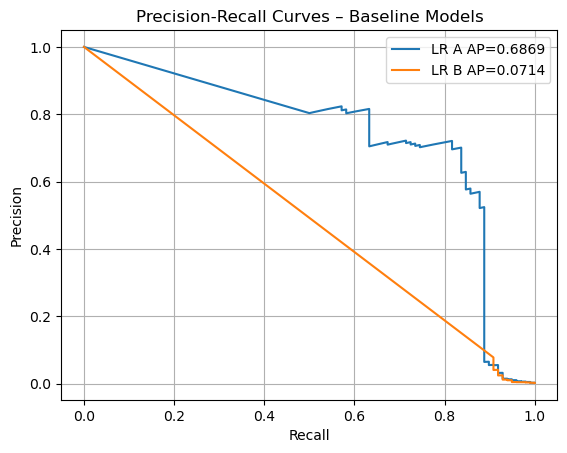

In [8]:
prec_a, rec_a, thr_a = precision_recall_curve(y_te, proba_a)
prec_b, rec_b, thr_b = precision_recall_curve(y_te, proba_b)

plt.figure()
plt.plot(rec_a, prec_a, label=f"LR A AP={ap_a:.4f}")
plt.plot(rec_b, prec_b, label=f"LR B AP={ap_b:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves – Baseline Models")
plt.legend()
plt.grid(True)
plt.show()
plt.close()


## Erste Exploration von Entscheidungsschwellen

Obwohl die finale Threshold-Entscheidung in einem späteren Notebook erfolgt,
werden hier exemplarisch verschiedene Schwellenwerte betrachtet,
um die Auswirkungen auf False Positives und False Negatives zu verstehen.

Diese Analyse dient ausschließlich dem Verständnis der Trade-offs.


In [9]:
def evaluate_threshold(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "threshold": threshold,
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    }


# Beispielhafte Thresholds (bewusst NICHT 0.5)
thresholds = [0.01, 0.02, 0.05, 0.10]

results = []

for t in thresholds:
    res_a = evaluate_threshold(y_te, proba_a, t)
    res_a["model"] = "LR_A_no_weights"
    results.append(res_a)

    res_b = evaluate_threshold(y_te, proba_b, t)
    res_b["model"] = "LR_B_balanced"
    results.append(res_b)

df_thresholds = pd.DataFrame(results)
df_thresholds


,threshold,precision,recall,tn,fp,fn,tp,model
0,0.01,0.729412,0.632653,56841,23,36,62,LR_A_no_weights
1,0.01,0.046966,0.908163,55058,1806,9,89,LR_B_balanced
2,0.02,0.729412,0.632653,56841,23,36,62,LR_A_no_weights
3,0.02,0.047340,0.908163,55073,1791,9,89,LR_B_balanced
4,0.05,0.738095,0.632653,56842,22,36,62,LR_A_no_weights
5,0.05,0.047901,0.908163,55095,1769,9,89,LR_B_balanced
6,0.10,0.756098,0.632653,56844,20,36,62,LR_A_no_weights
7,0.10,0.048528,0.908163,55119,1745,9,89,LR_B_balanced


## Interpretation im Fraud-Kontext

Die Ergebnisse werden nun in operative Auswirkungen übersetzt:

- False Negatives: durchgewunkener Betrug
- False Positives: blockierte legitime Transaktionen

Besonders relevant ist die Frage:
Wie viele zusätzliche False Positives entstehen,
um einen zusätzlichen Fraud-Fall zu verhindern?


In [10]:
def scale_to_100k(row, total_samples):
    factor = 100_000 / total_samples
    return {
        "FP_per_100k": row["fp"] * factor,
        "FN_per_100k": row["fn"] * factor,
        "TP_per_100k": row["tp"] * factor,
    }

total_test = len(y_te)

df_operational = df_thresholds.copy()
df_operational[["FP_per_100k", "FN_per_100k", "TP_per_100k"]] = (
    df_operational.apply(
        lambda r: pd.Series(scale_to_100k(r, total_test)), axis=1
    )
)

df_operational


,threshold,precision,recall,tn,fp,fn,tp,model,FP_per_100k,FN_per_100k,TP_per_100k
0,0.01,0.729412,0.632653,56841,23,36,62,LR_A_no_weights,40.377796,63.200028,108.844493
1,0.01,0.046966,0.908163,55058,1806,9,89,LR_B_balanced,3170.534742,15.800007,156.244514
2,0.02,0.729412,0.632653,56841,23,36,62,LR_A_no_weights,40.377796,63.200028,108.844493
3,0.02,0.047340,0.908163,55073,1791,9,89,LR_B_balanced,3144.201397,15.800007,156.244514
4,0.05,0.738095,0.632653,56842,22,36,62,LR_A_no_weights,38.622239,63.200028,108.844493
5,0.05,0.047901,0.908163,55095,1769,9,89,LR_B_balanced,3105.579158,15.800007,156.244514
6,0.10,0.756098,0.632653,56844,20,36,62,LR_A_no_weights,35.111127,63.200028,108.844493
7,0.10,0.048528,0.908163,55119,1745,9,89,LR_B_balanced,3063.445806,15.800007,156.244514


## Zusammenfassung & Ausblick

- Die Logistic Regression liefert eine stabile Baseline
- Class Weights verschieben den Trade-off Richtung höherem Recall
- Entscheidungsschwellen sind eine Business- und Risikoentscheidung

Im nächsten Schritt wird ein Neural Network trainiert,
das nur dann sinnvoll ist, wenn es diese Baseline
nachweislich verbessert.
